In [153]:
from pydtmc import MarkovChain
from networkx import DiGraph, get_edge_attributes,spring_layout, draw_networkx, draw_networkx_edge_labels, add_path
from matplotlib import pyplot
from numpy import random, ones, ndarray
from random import choice, seed, random as rnd
from math import cos

We will use a fixed seed for reproducibility. Later on, true values will be put in the json file to allow for a somewhat 'real' model.

In [154]:
seed(234)

We can create a directed weighted graph form scratch, where Markov chains can be deduced from the graph topology.
First, we will modelize clouds.
https://cartebateau.com/nuages

In [155]:
weather:DiGraph = DiGraph()

cloud_states:list[str] = [
    'Cirrus',
    'Cirrocumulus',
    'Cirrostratus',
    'Altocumulus',
    'Nimbostratus',
    'Altostratus',
    'Stratocumulus',
    'Stratus',
    'Cumulus',
    'Cumulonimbus'
]

weather.add_nodes_from(cloud_states)

# Creating artificial transition values
for state_a in cloud_states:
    distrib:ndarray = random.dirichlet(ones(len(cloud_states)),size=1)
    for i,state_b in enumerate(cloud_states):
        weather.add_edge(state_a,state_b,weight=distrib[0][i])

print(f"The graph contains {len(weather.nodes)} states.")

The graph contains 10 states.


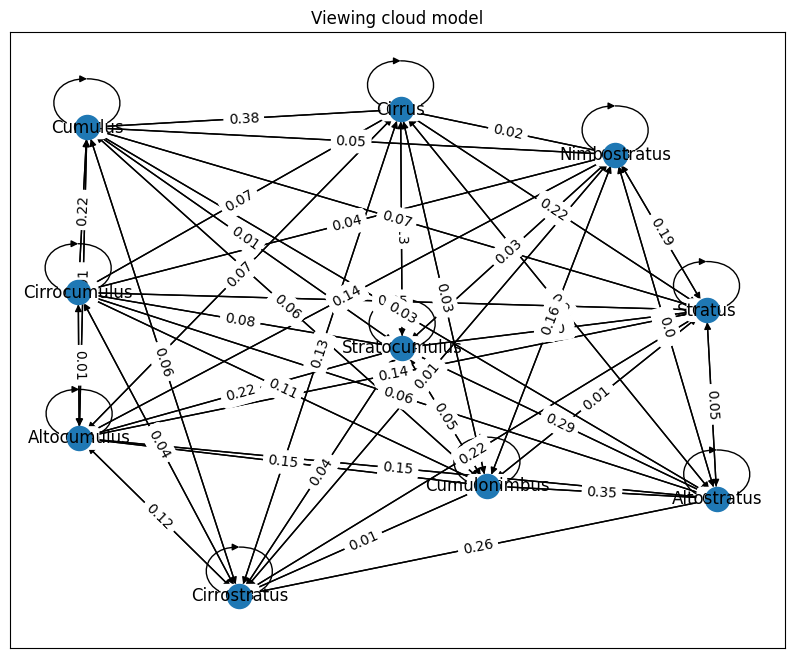

In [156]:
# Drawing the graph
pyplot.figure(figsize=(10,8))
pyplot.title("Viewing cloud model")
pos=spring_layout(weather)
draw_networkx(weather,pos)
labels = get_edge_attributes(weather,'weight')
for key,value in labels.items():
    labels[key] = round(value,2)
draw_networkx_edge_labels(weather,pos,edge_labels=labels)
pyplot.show()

Creating the Markov chain

In [157]:
probabilities:list = [
        [
            get_edge_attributes(weather,'weight')[(state_a,state_b)] for state_b in cloud_states
        ] for state_a in cloud_states
    ]
mc = MarkovChain(probabilities, cloud_states)
print(mc)


DISCRETE-TIME MARKOV CHAIN
 SIZE:           10
 RANK:           10
 CLASSES:        1
  > RECURRENT:   1
  > TRANSIENT:   0
 ERGODIC:        YES
  > APERIODIC:   YES
  > IRREDUCIBLE: YES
 ABSORBING:      NO
 MONOTONE:       NO
 REGULAR:        YES
 REVERSIBLE:     NO
 SYMMETRIC:      NO



In [158]:
sequence:list[str] = [choice(cloud_states)]
for i in range(1, 11):
    current_state = sequence[-1]
    next_state = mc.next(current_state, seed=7745)
    if next_state == current_state:
        # Do some subchain work
        pass
    sequence.append(next_state)

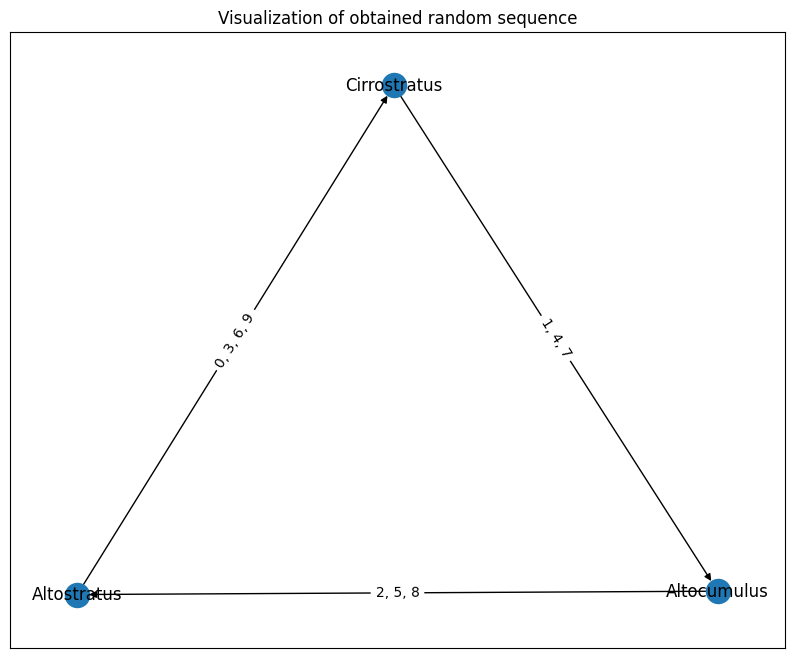

In [159]:
# Drawing the sequence
sequence_graph:DiGraph = DiGraph()
add_path(sequence_graph,sequence)
pyplot.figure(figsize=(10,8))
pyplot.title("Visualization of obtained random sequence")
pos=spring_layout(sequence_graph)
draw_networkx(sequence_graph,pos)
labels:dict = dict()
for i in range(len(sequence)-1):
    labels[(sequence[i],sequence[i+1])] = labels.get((sequence[i],sequence[i+1]),[]) + [str(i)]
for key,value in labels.items():
    labels[key] = ', '.join(labels[key])
draw_networkx_edge_labels(weather,pos,edge_labels=labels)
pyplot.show()

We can handle time and add its component to the Markov chain by changing the weights of the edges of the graph. Seasons can also have their influence, and so do temperature.

We will define a basic model of temperature.

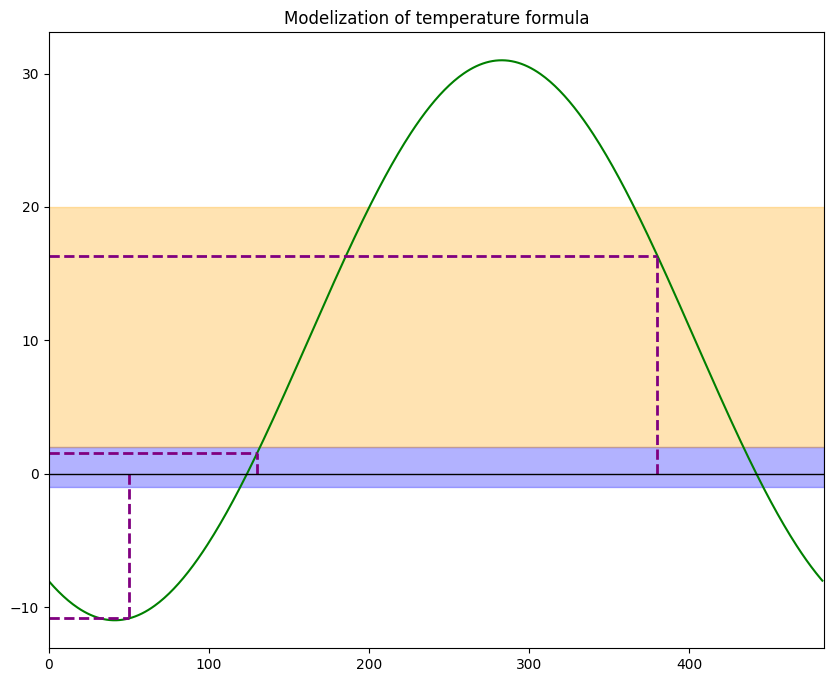

In [160]:
days:int = [50,130,380]

year_length:int = 484

temperature = lambda x:(20-42*cos(0.013*x - 0.534))/2

pyplot.figure(figsize=(10,8))
pyplot.title("Modelization of temperature formula")
pyplot.fill_between([x for x in range(-1,year_length+1)], [-1 for _ in range(-1,year_length+1)],[2 for x in range(-1,year_length+1)], color = 'blue', alpha = .3)
pyplot.fill_between([x for x in range(-1,year_length+1)], [2 for _ in range(-1,year_length+1)],[20 for x in range(-1,year_length+1)], color = 'orange', alpha = .3)
pyplot.plot([temperature(x) for x in range(0,year_length)], color = 'green')
for day in days:
    pyplot.vlines(x=[day], ymin=0, ymax=temperature(day), colors='purple', ls='--', lw=2)
    pyplot.hlines(y=[temperature(day)], xmin=0, xmax=day, colors='purple', ls='--', lw=2)
pyplot.hlines(y=[0], xmin=0, xmax=year_length, colors='black', lw=1)
pyplot.xlim((0,year_length))
pyplot.show()

We define weather states : temperatures where events can happen or no

In [161]:
weather_states:dict[str,tuple] = {
    'Neige':(-1,2),
    'Pluie':(2,20),
    'Nuage':(float('-inf'),float('inf')),
    'Dégagé':(float('-inf'),float('inf')),
    'Brouillard':(-2,10),
}

We will have weather regimes that, depending on the clouds, are susceptible or not to occur.

As example, we will look at the 'Altostratus' type, which can deliver snow with low enough temperatures (but not too low), and rain with hotter temperatures.

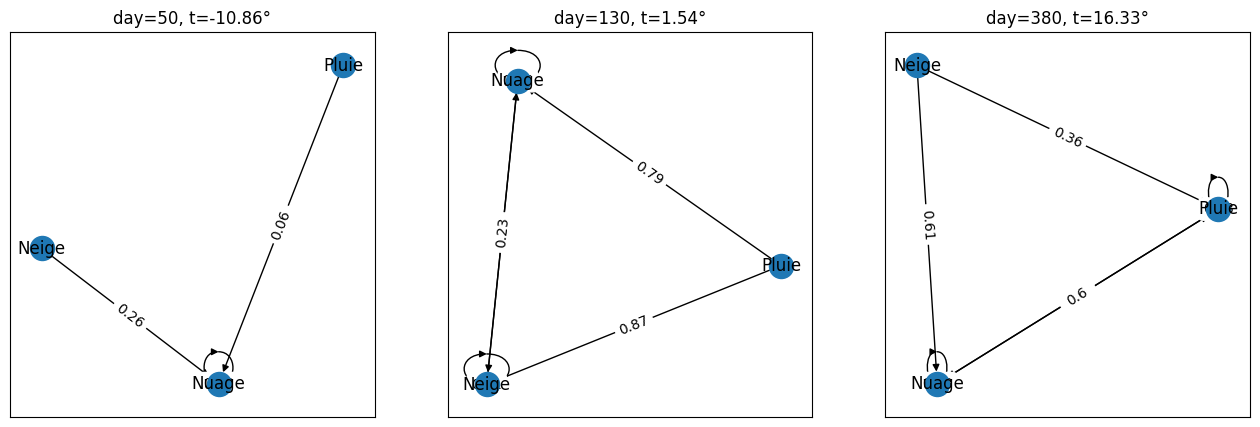

In [162]:
def subchain(day:int,possible_weathers:list[str]) -> DiGraph:
    chain:DiGraph = DiGraph()

    chain.add_nodes_from(possible_weathers)

    # Creating artificial transition values
    for state_a in possible_weathers:
        for state_b,(inf,sup) in [(weather,weather_states[weather]) for weather in possible_weathers]:
            if temperature(day) >= inf and temperature(day) <= sup:
                chain.add_edge(state_a,state_b,weight=rnd())
    return chain

fig, axs = pyplot.subplots(1,len(days),figsize=(16,5))
for i,day in enumerate(days):
    w_subchain:DiGraph = subchain(day,['Neige','Pluie','Nuage'])
    axs[i].set_title(f"day={day}, t={round(temperature(day),2)}°")
    pos=spring_layout(w_subchain)
    draw_networkx(w_subchain,pos,ax=axs[i])
    labels = get_edge_attributes(w_subchain,'weight')
    for key,value in labels.items():
        labels[key] = round(value,2)
    draw_networkx_edge_labels(w_subchain,pos,edge_labels=labels,ax=axs[i])
pyplot.show()

We will map could states to their chains

In [163]:
weather_regimes:dict = {
    'Altostratus':['Neige','Pluie','Nuage']
}

We need a function that takes as input a graph and creates a markov chain, then inits it at a correct position

In [164]:
def init_markov(graph:DiGraph) -> MarkovChain:
    nodes:list = list(graph.nodes.keys())
    probabilities:list = [
            [
                get_edge_attributes(graph,'weight',default=0).get((state_a,state_b),0) for state_b in nodes
            ] for state_a in nodes
        ]
    probabilities = [[float(i)/sum(raw) for i in raw] for raw in probabilities]
    smc:MarkovChain = MarkovChain(probabilities, nodes)
    current_state:str = choice(nodes) # doing so assures we're not using a incompatible value
    return smc,smc.next(current_state)
    

In [165]:
sequence:list[str] = [('Nimbostratus','Nuage')]
for day_interval in range(110, 140):
    for time_interval in range(0,10):
        current_state,current_regime = sequence[-1]
        next_state = mc.next(current_state)
        if next_state == current_state and time_interval != 0:
            regime = rg.next(current_regime)
        else:
            rg, regime = init_markov(subchain(time_interval,weather_regimes.get(next_state,['Nuage','Dégagé'])))
        sequence.append((next_state,regime))

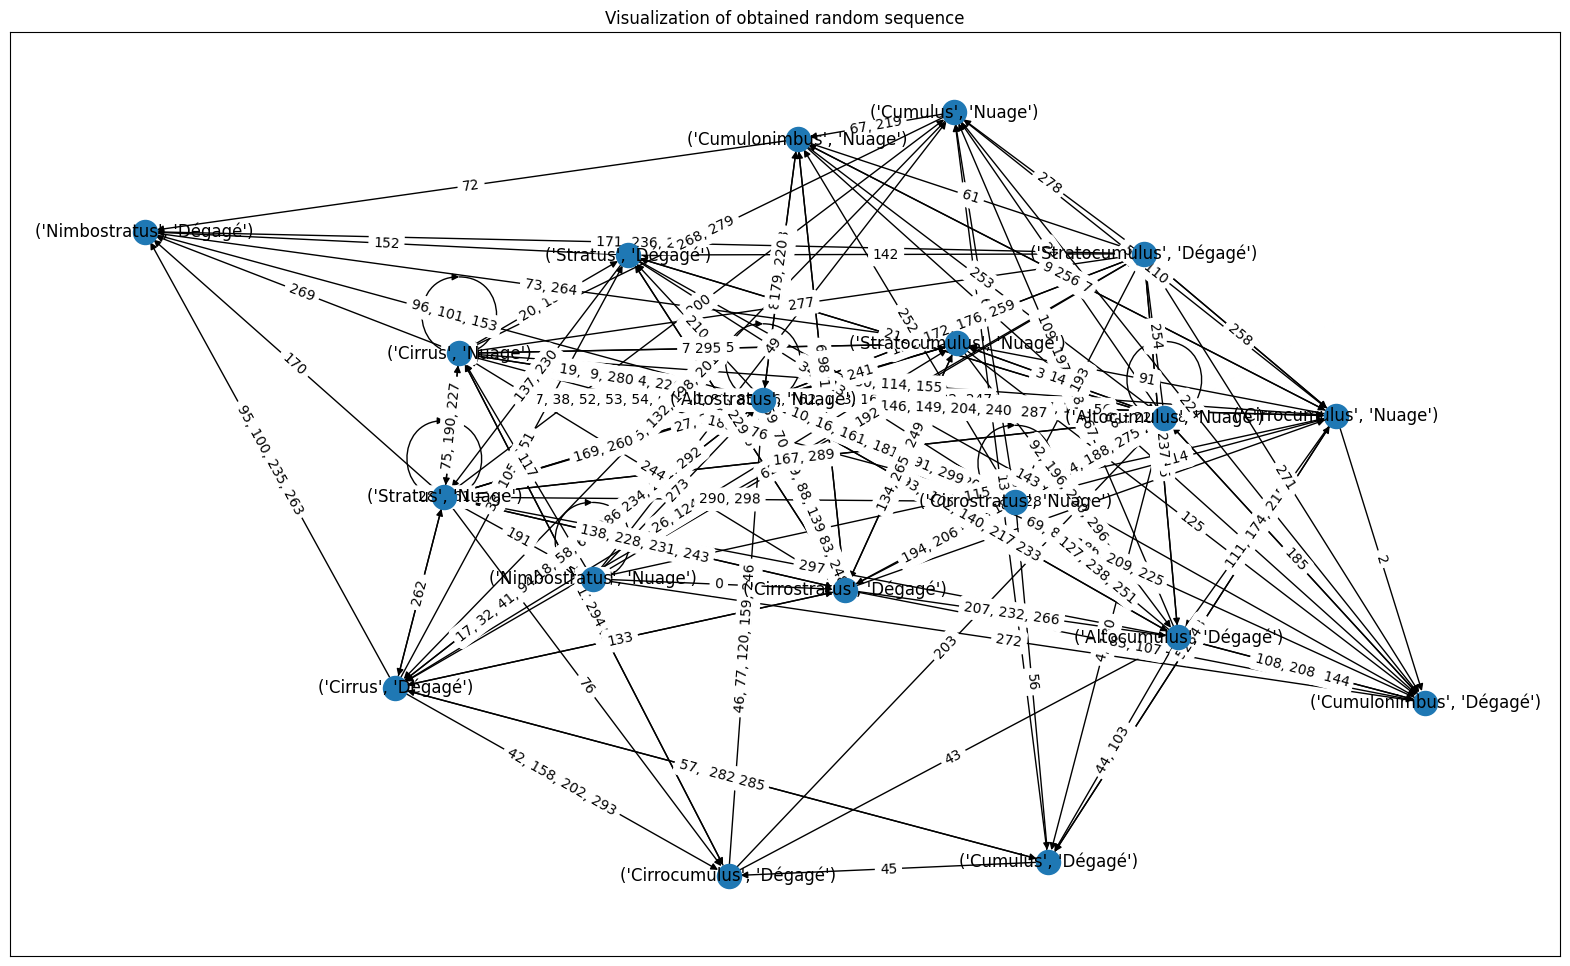

In [169]:
# Drawing the sequence
sequence_graph:DiGraph = DiGraph()
add_path(sequence_graph,sequence)
pyplot.figure(figsize=(20,12))
pyplot.title("Visualization of obtained random sequence")
pos=spring_layout(sequence_graph)
draw_networkx(sequence_graph,pos)
labels:dict = dict()
for i in range(len(sequence)-1):
    labels[(sequence[i],sequence[i+1])] = labels.get((sequence[i],sequence[i+1]),[]) + [str(i)]
for key,value in labels.items():
    labels[key] = ', '.join(labels[key])
draw_networkx_edge_labels(weather,pos,edge_labels=labels)
pyplot.show()